In [1]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torchmetrics
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import lightning as L
from lightning.pytorch.loggers import CSVLogger

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# to get deterministic output
torch.manual_seed(123)

sys.path.append(os.path.abspath(".."))

### Loading the Dataset

In [2]:
train_dataset = datasets.MNIST(root="../datasets/mnist", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="../datasets/mnist", train=False, transform=transforms.ToTensor())

print("Train set size:", len(train_dataset))
print("Test set size :", len(test_dataset))

Train set size: 60000
Test set size : 10000


### Data Preprocessing

In [3]:
train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000], generator=torch.Generator().manual_seed(42))

print("Train set size     :", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size      :", len(test_dataset))

Train set size     : 55000
Validation set size: 5000
Test set size      : 10000


### Defining the DataLoader

In [4]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [5]:
train_counter = Counter()
for _, labels in train_loader:
    train_counter.update(labels.tolist())
print("Training label distribution:")
print(sorted(train_counter.items()))
 
val_counter = Counter()
for _, labels in val_loader:
    val_counter.update(labels.tolist())
print("\nValidation label distribution:")
print(sorted(val_counter.items()))
    
test_counter = Counter()
for _, labels in test_loader:
    test_counter.update(labels.tolist())
print("\nTest label distribution:")
print(sorted(test_counter.items()))

Training label distribution:
[(0, 5441), (1, 6190), (2, 5477), (3, 5600), (4, 5346), (5, 5000), (6, 5422), (7, 5710), (8, 5347), (9, 5467)]

Validation label distribution:
[(0, 482), (1, 552), (2, 481), (3, 531), (4, 496), (5, 421), (6, 496), (7, 555), (8, 504), (9, 482)]

Test label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


### Visualizing the dataset

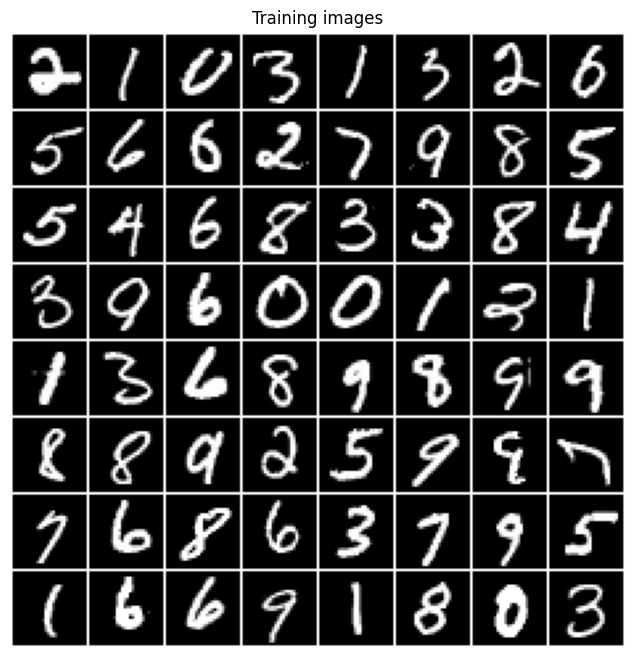

In [6]:
import torchvision

for images, _ in train_loader:  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(
    torchvision.utils.make_grid(
        images[:64], 
        padding=1,
        pad_value=1.0,
        normalize=True),
        (1, 2, 0)))
plt.show()

### Zero-Rule baseline (majority class classifier)

In [7]:
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print(f"Accuracy when always predicting the majority class: {baseline_acc:.2f}")

Majority class: 1
Accuracy when always predicting the majority class: 0.11


### Defining the Model

In [8]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [9]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)
    
    def common_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = F.cross_entropy(logits, true_labels)
        pred_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, pred_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, pred_labels = self.common_step(batch)        
        self.train_acc(pred_labels, true_labels)
        self.log("train_loss", loss)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, pred_labels = self.common_step(batch)        
        self.val_acc(pred_labels, true_labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_acc, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        loss, true_labels, pred_labels = self.common_step(batch)
        self.test_acc(pred_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

### Training the model

In [10]:
pytorch_model = PyTorchMLP(num_features=784, num_classes=10)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

trainer = L.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=False,
)
trainer.fit(model=lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | PyTorchMLP         | 40.8 K | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Nova\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
c:\Users\Nova\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Save and Load the Checkpoint

In [11]:
# save the checkpoint
# CP_PATH = "model.ckpt"
# trainer.save_checkpoint(CP_PATH)

# load the checkpoint
# pytorch_model = PyTorchMLP(num_features=784, num_classes=10)
# lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=CP_PATH, model=pytorch_model)

### Evaluate the Model

In [12]:
train_acc = trainer.validate(dataloaders=train_loader)[0]["val_acc"]
val_acc = trainer.validate(dataloaders=val_loader)[0]["val_acc"]
test_acc = trainer.test(dataloaders=test_loader)[0]["test_acc"]

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Val Accuracy  : {val_acc:.2f}")
print(f"Test Accuracy : {test_acc:.2f}")

c:\Users\Nova\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:149: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/my-model\version_0\checkpoints\epoch=9-step=8600.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/my-model\version_0\checkpoints\epoch=9-step=8600.ckpt
c:\Users\Nova\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9752545356750488     │
│         val_loss          │    0.08571726828813553    │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/my-model\version_0\checkpoints\epoch=9-step=8600.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/my-model\version_0\checkpoints\epoch=9-step=8600.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9606000185012817     │
│         val_loss          │    0.13910561800003052    │
└───────────────────────────┴───────────────────────────┘

c:\Users\Nova\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/my-model\version_0\checkpoints\epoch=9-step=8600.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/my-model\version_0\checkpoints\epoch=9-step=8600.ckpt
c:\Users\Nova\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9672999978065491     │
└───────────────────────────┴───────────────────────────┘

Train Accuracy: 0.98
Val Accuracy  : 0.96
Test Accuracy : 0.97


### Vizualize Confusion Matrix

In [13]:
class_dict = {0: '0',
              1: '1',
              2: '2',
              3: '3',
              4: '4',
              5: '5',
              6: '6',
              7: '7',
              8: '8',
              9: '9'}

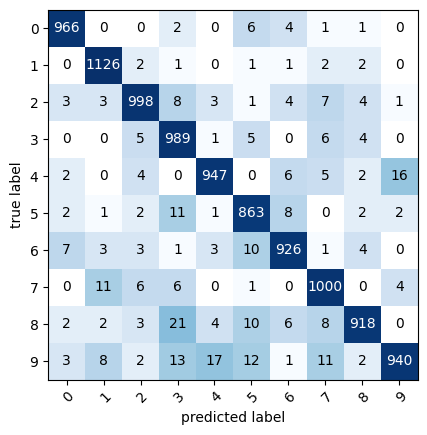

In [14]:
import matplotlib
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

cmat = ConfusionMatrix(task="multiclass", num_classes=len(class_dict))

for x, y in test_loader:
    with torch.inference_mode():
        pred = lightning_model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()
fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm()
)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

### Vizualize Training Metrices

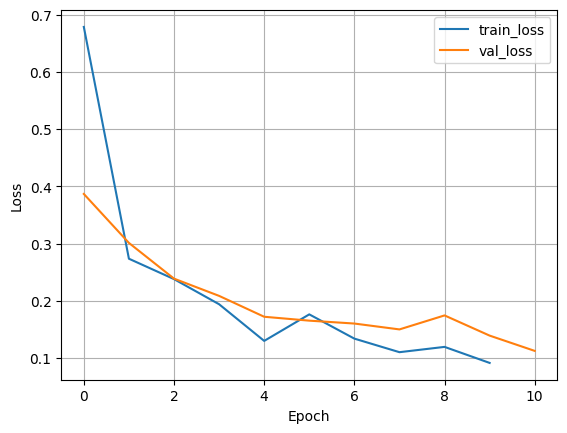

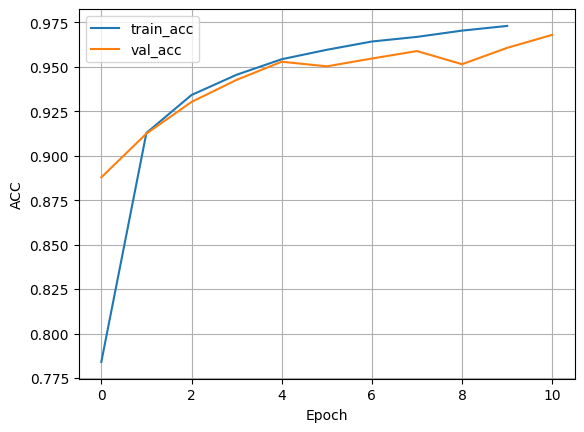

In [15]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
agg_col = "epoch"
aggreg_metrics = []
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(grid=True, legend=True, xlabel="Epoch", ylabel="Loss")
df_metrics[["train_acc", "val_acc"]].plot(grid=True, legend=True, xlabel="Epoch", ylabel="ACC")
plt.show()

### Visualizing the Results

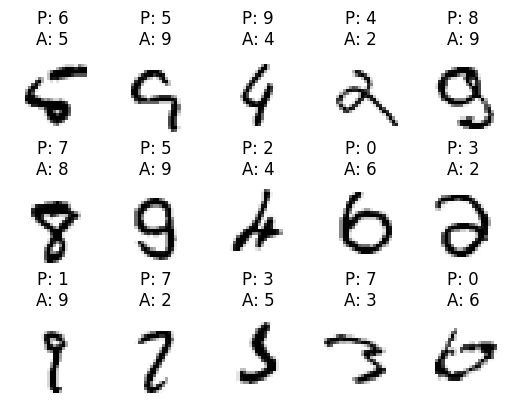

In [17]:
from modules.plotting_helper import show_failures
failures = show_failures(model=lightning_model, data_loader=test_loader, class_dict=class_dict)
# plt.savefig('failures.pdf')